# Importing Modules and initializing variables

Importing necessary modules that will be later required whilst training model


In [79]:
import numpy as np
import random
import heapq
import requests
import math
import matplotlib.pyplot as plt
import pickle
import pyproj
import sklearn


import contextily as ctx  # for map tiles
import matplotlib.transforms as mtransforms
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from pyproj import Transformer

Versions of the modules

In [80]:
print(np.__version__)
print(requests.__version__)
print(ctx.__version__)
print(pyproj.__version__)
print(sklearn.__version__)

2.0.2
2.32.3
1.6.2
3.6.1
1.5.2


Global Variables

In [25]:
GRID_SIZE = 10
WEATHER_API_KEY = 'yourmom'
WIND_THRESHOLD = 6.0
RAIN_THRESHOLD = 1.5

# Utilizing Open Weather services for wind and env

Extracting wind speed and wind degree

In [4]:
def fetch_cell_data(args):
    """
    Called by ThreadPoolExecutor for each cell.
    Returns (y, x, blocked, (wy, wx)).
    """
    (y, x, min_lat, max_lat, min_lon, max_lon,
     grid_size, wind_thresh, rain_thresh,
     api_key) = args

    lat_step = (max_lat - min_lat) / grid_size
    lon_step = (max_lon - min_lon) / grid_size
    cell_lat = min_lat + (y + 0.5)*lat_step
    cell_lon = min_lon + (x + 0.5)*lon_step

    url = f"https://api.openweathermap.org/data/2.5/weather?lat={cell_lat}&lon={cell_lon}&appid={api_key}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    wind_data = data.get("wind", {})
    wind_speed = wind_data.get("speed", 0.0)
    wind_deg   = wind_data.get("deg", 0)
    radians = math.radians(wind_deg)
    wx = wind_speed * math.sin(radians)
    wy = -wind_speed * math.cos(radians)

    rain_1h = 0.0
    if "rain" in data and "1h" in data["rain"]:
        rain_1h = data["rain"]["1h"]
    snow_1h = 0.0
    if "snow" in data and "1h" in data["snow"]:
        snow_1h = data["snow"]["1h"]

    blocked = 1 if (wind_speed > wind_thresh or (rain_1h + snow_1h) > rain_thresh) else 0

    return (y, x, blocked, (wy, wx))

Creating 2 by 2 dimension environment using winds

In [18]:
def generate_environment_multi_owm_concurrent(
    min_lat, max_lat, min_lon, max_lon,
    grid_size=GRID_SIZE,
    wind_threshold=WIND_THRESHOLD,
    rain_threshold=RAIN_THRESHOLD,
    api_key=WEATHER_API_KEY,
    max_workers=10
):
    
    """
    Parallel version: fetch weather for each cell concurrently
    to reduce total wait time.

    Returns (env, wind):
      env[y,x] = 0 or 1 (blocked)
      wind[y,x] = (wy, wx)
    """
    
    env = np.zeros((grid_size, grid_size), dtype=int)
    wind = np.zeros((grid_size, grid_size, 2), dtype=float)
    tasks = []
    for y in range(grid_size):
        for x in range(grid_size):
            tasks.append((
                y, x,
                min_lat, max_lat, min_lon, max_lon,
                grid_size,
                wind_threshold, rain_threshold,
                api_key
            ))
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(fetch_cell_data, tasks))
    for (y, x, blocked, (wy, wx)) in results:
        env[y, x] = blocked
        wind[y, x] = (wy, wx)
    return env, wind

# A* Path Planner

Using A star algorithm for supervised imitation learning

In [6]:
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(node, grid_size):
    (y, x) = node
    for dy, dx in [(0,1),(0,-1),(1,0),(-1,0)]:
        ny, nx = y+dy, x+dx
        if 0 <= ny < grid_size and 0 <= nx < grid_size:
            yield (ny, nx)

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

def a_star(env, wind, start, goal):
    grid_size = env.shape[0]
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = { (y,x): float('inf') for y in range(grid_size) for x in range(grid_size) }
    f_score = { (y,x): float('inf') for y in range(grid_size) for x in range(grid_size) }
    g_score[start] = 0
    f_score[start] = heuristic(start, goal)
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)
        for nxt in get_neighbors(current, grid_size):
            cy, cx = current
            ny, nx = nxt
            if env[ny, nx] == 1:
                continue  # blocked cell
            step_cost = 1.0 + np.hypot(*wind[ny, nx])
            tentative_g = g_score[current] + step_cost
            if tentative_g < g_score[nxt]:
                came_from[nxt] = current
                g_score[nxt] = tentative_g
                f_score[nxt] = tentative_g + heuristic(nxt, goal)
                heapq.heappush(open_set, (f_score[nxt], nxt))
    return None

Creating State Action pairs to follow policy

In [7]:
def path_to_state_action_pairs(path, wind, goal):
    
    """
    Converts each step in 'path' to a supervised (state->action) example:
      - state = (current_y, current_x, wy, wx, goal_y, goal_x)
      - action = up/down/left/right
    """
    
    pairs = []
    for i in range(len(path)-1):
        cy, cx = path[i]
        ny, nx = path[i+1]
        if ny < cy:
            action = 0  # up
        elif ny > cy:
            action = 1  # down
        elif nx < cx:
            action = 2  # left
        else:
            action = 3  # right
        wy, wx = wind[cy, cx]
        gy, gx = goal
        state = (cy, cx, wy, wx, gy, gx)
        pairs.append((state, action))
    return pairs

# Training a supervised model


Creating a function to convert the grid to latitude data

In [46]:
def define_bounding_box(lat_start, lon_start, lat_goal, lon_goal, extra_margin=0.2):
    """
    Expands a bounding box around start & goal with an 'extra_margin' fraction
    so there's room for alternate routes.
    """
    min_lat = min(lat_start, lat_goal)
    max_lat = max(lat_start, lat_goal)
    min_lon = min(lon_start, lon_goal)
    max_lon = max(lon_start, lon_goal)

    lat_range = max_lat - min_lat
    lon_range = max_lon - min_lon

    min_lat -= lat_range * extra_margin
    max_lat += lat_range * extra_margin
    min_lon -= lon_range * extra_margin
    max_lon += lon_range * extra_margin

    return (min_lat, max_lat, min_lon, max_lon)

def latlon_to_grid(lat, lon, min_lat, max_lat, min_lon, max_lon, grid_size):
    """
    Maps lat/lon to grid coords in [0..grid_size-1].
    Clips if lat/lon is outside bounding box.
    """
    lat = max(min_lat, min(lat, max_lat))
    lon = max(min_lon, min(lon, max_lon))

    frac_y = 0.0
    if (max_lat - min_lat) != 0:
        frac_y = (lat - min_lat) / (max_lat - min_lat)

    frac_x = 0.0
    if (max_lon - min_lon) != 0:
        frac_x = (lon - min_lon) / (max_lon - min_lon)

    gy = int(frac_y * (grid_size - 1))
    gx = int(frac_x * (grid_size - 1))
    return (gy, gx)

def grid_to_latlon(gy, gx, min_lat, max_lat, min_lon, max_lon, grid_size):
    """
    Inverse: from grid coords to lat/lon bounding box.
    """
    frac_y = gy / (grid_size - 1)
    frac_x = gx / (grid_size - 1)
    lat = min_lat + frac_y*(max_lat - min_lat)
    lon = min_lon + frac_x*(max_lon - min_lon)
    return (lat, lon)


def latlon_route_from_grid_path(path, min_lat, max_lat, min_lon, max_lon, grid_size):
    """
    Convert a path in grid coords to a list of (lat, lon).
    """
    latlon_path = []
    for (gy, gx) in path:
        lat_c, lon_c = grid_to_latlon(gy, gx, min_lat, max_lat, min_lon, max_lon, grid_size)
        latlon_path.append((lat_c, lon_c))
    return latlon_path

Inferencing model

In [9]:
def model_based_route_with_fallback(model, env, wind, start, goal, max_steps=100):
    """
    Step-by-step route using the model's predicted action.
    If that action leads to a blocked cell, we try other directions (fallback).
    """
    current = start
    path = []
    grid_size = env.shape[0]
    for _ in range(max_steps):
        path.append(current)
        if current == goal:
            return path
        cy, cx = current
        wy, wx = wind[cy, cx]
        gy, gx = goal
        state = np.array([cy, cx, wy, wx, gy, gx], dtype=float).reshape(1, -1)
        primary_action = model.predict(state)[0]
        fallback_order = [0, 1, 2, 3]
        fallback_order.remove(primary_action)
        candidate_actions = [primary_action] + fallback_order
        picked_action = None
        for action in candidate_actions:
            ny, nx = apply_action(cy, cx, action)
            if not (0 <= ny < grid_size and 0 <= nx < grid_size):
                continue
            if env[ny, nx] == 1:
                continue
            picked_action = action
            break
        if picked_action is None:
            return None
        else:
            ny, nx = apply_action(cy, cx, picked_action)
            current = (ny, nx)
    return None

def apply_action(cy, cx, action):
    """
    0=up,1=down,2=left,3=right
    """
    if action == 0:
        return (cy-1, cx)
    elif action == 1:
        return (cy+1, cx)
    elif action == 2:
        return (cy, cx-1)
    else:
        return (cy, cx+1)


# Visualizing the model

Visualize the grid for ease in understanding the model.

In [10]:
def quick_visual(path, title="LatLon Route"):
    """
    Simple example: 
    1) Convert lat/lon -> web mercator
    2) Plot a line on top of a basemap from contextily.
    """

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(env, cmap='gray_r', origin='upper')
    skip = 1
    Y, X = np.mgrid[0:env.shape[0], 0:env.shape[1]]
    U = wind_field[..., 1]
    V = wind_field[..., 0]
    ax.quiver(X[::skip, ::skip], Y[::skip, ::skip],
              U[::skip, ::skip], V[::skip, ::skip],
              color='blue', scale=5, alpha=0.7)
    if path:
        py = [p[0] for p in path]
        px = [p[1] for p in path]
        ax.plot(px, py, 'ro-')
    ax.plot(start_grid[1], start_grid[0], 'gs', label='Start')
    ax.plot(goal_grid[1], goal_grid[0], 'rx', label='Goal')
    ax.invert_yaxis()
    ax.set_title(title)
    ax.legend()
    plt.show()
    
def visualize_latlon_route_on_map(latlon_route, title="LatLon Route"):
    """
    Converts the lat/lon route to Web Mercator and overlays it on a basemap.
    Uses contextily. If Stamen.TonerLite is not available, falls back to OSM.
    """
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    xs, ys = [], []
    for (lat, lon) in latlon_route:
        x, y = transformer.transform(lon, lat)
        xs.append(x)
        ys.append(y)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(xs, ys, 'ro-', label='Route')
    ax.set_xlim(min(xs)-100, max(xs)+100)
    ax.set_ylim(min(ys)-100, max(ys)+100)
    try:
        ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.Stamen.TonerLite)
    except Exception as e:
        print("Stamen provider not available, falling back to OSM Mapnik.", e)
        ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(title)
    ax.legend()
    plt.show()

# Running the model, training and testing

In [47]:
def train_on_multiple_scenarios(scenario_list):
    """
    scenario_list: a list of tuples (lat_start, lon_start, lat_goal, lon_goal).
    We'll build a big dataset from all these scenarios and train one model.
    Returns (model, X_data, y_data).
    """
    from sklearn.ensemble import RandomForestClassifier

    X_data, y_data = [], []
    model = RandomForestClassifier(n_estimators=10, random_state=42)

    for idx, (lat_s, lon_s, lat_g, lon_g) in enumerate(scenario_list):
        print(f"\n--- Scenario {idx+1}/{len(scenario_list)} ---")
        print(f"Start lat/lon: ({lat_s}, {lon_s}) -> Goal lat/lon: ({lat_g}, {lon_g})")

        # bounding box
        (min_lat, max_lat, min_lon, max_lon) = define_bounding_box(lat_s, lon_s, lat_g, lon_g, extra_margin=0.3)

        # build environment
        env, wind = generate_environment_multi_owm_concurrent(
            min_lat, max_lat, min_lon, max_lon,
            grid_size=GRID_SIZE,
            wind_threshold=WIND_THRESHOLD,
            rain_threshold=RAIN_THRESHOLD,
            api_key=WEATHER_API_KEY,
        )

        # lat/lon -> grid
        start_grid = latlon_to_grid(lat_s, lon_s, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
        goal_grid  = latlon_to_grid(lat_g, lon_g, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
        print("Start grid:", start_grid, "Goal grid:", goal_grid)

        # run A*
        path = a_star(env, wind, start_grid, goal_grid)
        print("A* path:", path)

        if not path or len(path) < 2:
            print("No valid path => skip scenario.")
            continue

        # convert path to lat/lon => visualize on a real map
        latlon_path = latlon_route_from_grid_path(path, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
        visualize_latlon_route_on_map(latlon_path, title=f"Scenario {idx+1} A* Route")

        # gather training data
        pairs = path_to_state_action_pairs(path, wind, goal_grid)
        for (st, ac) in pairs:
            X_data.append(st)
            y_data.append(ac)

        print(f"Scenario {idx+1}: Collected {len(pairs)} samples. Total so far = {len(X_data)}")

    # train final model
    if len(X_data) == 0:
        print("No data => cannot train.")
        return None, None, None
    X_np = np.array(X_data, dtype=float)
    y_np = np.array(y_data, dtype=int)
    model.fit(X_np, y_np)
    print(f"\nTrained model on {len(X_data)} total samples from {len(scenario_list)} scenario(s).")
    return model, X_np, y_np

In [61]:
def generate_random_scenario():
    # For example, generate lat in [40,50] and lon in [-80,-70]
    lat_start = random.uniform(-80,80)
    lon_start = random.uniform(-170,170)
    lat_goal = lat_start+random.uniform(0,1)*random.uniform(0.8,5)
    lon_goal = lon_start+random.uniform(0,1)*random.uniform(0.8,5)
    return (lat_start, lon_start, lat_goal, lon_goal)

In [ ]:
if __name__ == "__main__":
    # Generate 100 random training scenarios
    scenario_list = [generate_random_scenario() for _ in range(1000)]
    model, X_np, y_np = train_on_multiple_scenarios(scenario_list)
    if model is None:
        print("No training data collected. Exiting.")
        sys.exit(0)
    with open("route_model_multi.pkl", "wb") as f:
        pickle.dump(model, f)
    print("Saved trained model to route_model_multi.pkl")

    # Define one new unique scenario to test on (outside the training set)
    test_scenario = (55.0, -75.0, 54.0, -74.0)
    print("\n--- Testing on new scenario ---")
    lat_s, lon_s, lat_g, lon_g = test_scenario
    (min_lat, max_lat, min_lon, max_lon) = define_bounding_box(lat_s, lon_s, lat_g, lon_g, extra_margin=0.3)
    env_test, wind_test = generate_environment_multi_owm_concurrent(
        min_lat, max_lat, min_lon, max_lon,
        grid_size=GRID_SIZE,
        wind_threshold=WIND_THRESHOLD,
        rain_threshold=RAIN_THRESHOLD,
        api_key=WEATHER_API_KEY,
    )
    start_grid_test = latlon_to_grid(lat_s, lon_s, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    goal_grid_test  = latlon_to_grid(lat_g, lon_g, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    print("Test scenario: Grid Start:", start_grid_test, "Grid Goal:", goal_grid_test)
    fallback_route_test = model_based_route_with_fallback(model, env_test, wind_test, start_grid_test, goal_grid_test, max_steps=200)
    print("Test scenario: Model-based fallback route (grid coords):", fallback_route_test)
    if fallback_route_test is None:
        print("No route found by the model in the test scenario.")
    else:
        test_latlon_route = []
        for (gy, gx) in fallback_route_test:
            lat_c, lon_c = grid_to_latlon(gy, gx, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
            test_latlon_route.append((lat_c, lon_c))
        print("Test scenario: Model-based route in lat/lon:")
        for p in test_latlon_route:
            print(p)
        visualize_latlon_route_on_map(test_latlon_route, title="Test Scenario Route on Map")

Start grid: (7, 7)
Goal grid: (1, 1)
A* path (grid coords): [(7, 7), (7, 6), (7, 5), (6, 5), (5, 5), (4, 5), (4, 4), (4, 3), (4, 2), (3, 2), (2, 2), (1, 2), (1, 1)]
Trained model on route of length: 13
Model-based fallback route (grid coords): [(7, 7), (7, 6), (7, 5), (6, 5), (5, 5), (4, 5), (4, 4), (4, 3), (4, 2), (3, 2), (2, 2), (1, 2), (1, 1)]


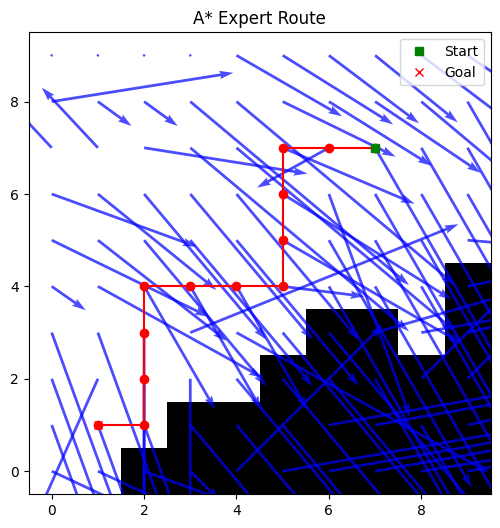

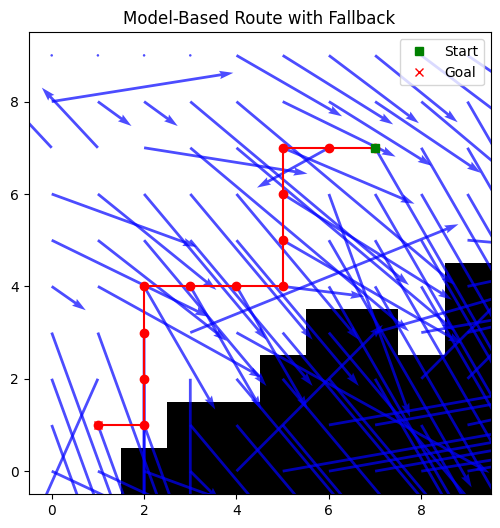

Model-based fallback route in lat/lon:
(43.56812, -70.761363)
(43.51256444444444, -70.99469633333334)
(43.51256444444444, -71.17247411111111)
(43.334786666666666, -71.17247411111111)
(43.15700888888889, -71.17247411111111)
(42.97923111111111, -71.17247411111111)
(42.97923111111111, -71.35025188888889)
(42.97923111111111, -71.52802966666667)
(42.97923111111111, -71.70580744444445)
(42.801453333333335, -71.70580744444445)
(42.62367555555556, -71.70580744444445)
(42.44589777777778, -71.70580744444445)
(42.56812, -71.761363)
Stamen provider not available, falling back to OSM Mapnik. Stamen


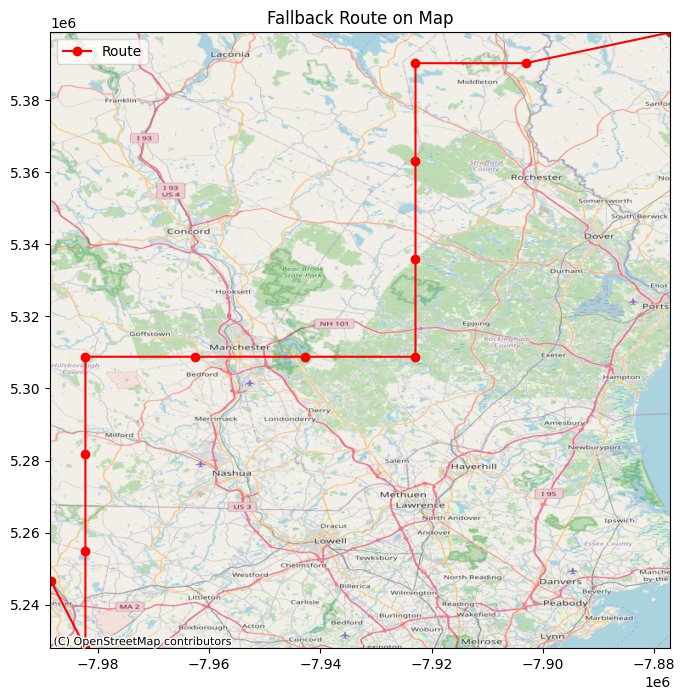

Model saved to route_model.pkl


In [39]:
if __name__ == "__main__":
    
    # Example: real lat/lon for start & goal
    lat_start, lon_start = 43.568120, -70.761363
    lat_goal,  lon_goal  = 42.568120, -71.761363

    # 1) Define bounding box around start & goal with extra margin.
    (min_lat, max_lat, min_lon, max_lon) = define_bounding_box(
        lat_start, lon_start, lat_goal, lon_goal, extra_margin=0.3
    )

    # 2) Build environment concurrently (this may still take time if GRID_SIZE is high).
    env, wind_field = generate_environment_multi_owm_concurrent(
        min_lat, max_lat, min_lon, max_lon,
        grid_size=GRID_SIZE,
        api_key=WEATHER_API_KEY,
        max_workers=10
    )

    # 3) Convert start and goal lat/lon to grid coordinates.
    start_grid = latlon_to_grid(lat_start, lon_start, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    goal_grid  = latlon_to_grid(lat_goal, lon_goal, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    print("Start grid:", start_grid)
    print("Goal grid:", goal_grid)

    # 4) Run A* to generate the "expert" route.
    astar_path = a_star(env, wind_field, start_grid, goal_grid)
    print("A* path (grid coords):", astar_path)

    # If no path is found, exit gracefully.
    if not astar_path or len(astar_path) < 2:
        print("No A* path found => cannot train the model.")

    else:
        # 5) Build training data from the A* path.
        pairs = path_to_state_action_pairs(astar_path, wind_field, goal_grid)
        X_data, y_data = [], []
        for (st, ac) in pairs:
            X_data.append(st)
            y_data.append(ac)
        X_np = np.array(X_data, dtype=float)
        y_np = np.array(y_data, dtype=int)

        # 6) Train the model (RandomForest).
        model = RandomForestClassifier(n_estimators=10, random_state=42)
        model.fit(X_np, y_np)
        print("Trained model on route of length:", len(astar_path))

        # 7) Test the trained model on the same environment using fallback.
        fallback_route = model_based_route_with_fallback(model, env, wind_field, start_grid, goal_grid, max_steps=200)
        print("Model-based fallback route (grid coords):", fallback_route)

        # Visualize grid routes (you can use your quick_visual or visualize_latlon_route_on_map functions)
        quick_visual(astar_path, "A* Expert Route")
        quick_visual(fallback_route, "Model-Based Route with Fallback")

        # 8) Convert the fallback route from grid coordinates to lat/lon.
        if fallback_route:
            latlon_route = []
            for (gy, gx) in fallback_route:
                lat_c, lon_c = grid_to_latlon(gy, gx, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
                latlon_route.append((lat_c, lon_c))
            
            latlon_route[-1] = (lat_goal,  lon_goal)

            latlon_route[0] = (lat_start, lon_start)
            print("Model-based fallback route in lat/lon:")
            for coords in latlon_route:
                print(coords)
            visualize_latlon_route_on_map(latlon_route, title="Fallback Route on Map")
        else:
            print("Model fallback route failed in the current scenario.")

        # 9) Save the trained model for later deployment.
        with open("route_model.pkl", "wb") as f:
            pickle.dump(model, f)
        print("Model saved to route_model.pkl")

In [77]:
if __name__ == "__main__":

    # 1) Load the pre-trained model
    try:
        with open("route_model_multi.pkl", "rb") as f:
            model = pickle.load(f)
        print("Loaded model from route_model.pkl")
    except FileNotFoundError:
        print("Error: route_model.pkl not found. Ensure you have a trained model file.")

    # 2) Define new lat/lon scenario
    lat_start2, lon_start2 = -25.922643, 134.755
    lat_goal2,  lon_goal2  = -24.922643, 134.755

    # 3) Build environment
    (min_lat, max_lat, min_lon, max_lon) = define_bounding_box(lat_start2, lon_start2, lat_goal2, lon_goal2, extra_margin=0.3)
    env, wind_field = generate_environment_multi_owm_concurrent(
        min_lat, max_lat, min_lon, max_lon,
        grid_size=GRID_SIZE,
        api_key=WEATHER_API_KEY,
        wind_threshold=WIND_THRESHOLD,
        rain_threshold=RAIN_THRESHOLD
    )

    # 4) Convert start/goal => grid coords
    start_grid2 = latlon_to_grid(lat_start2, lon_start2, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    goal_grid2  = latlon_to_grid(lat_goal2, lon_goal2, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
    print("Start grid (new scenario):", start_grid2)
    print("Goal grid (new scenario):", goal_grid2)

    # 5) Model fallback route
    fallback_route2 = model_based_route_with_fallback(model, env, wind_field, start_grid2, goal_grid2, max_steps=200)
    print("Model-based fallback route (new scenario):", fallback_route2)

    # 6) If route is None => check reason
    if fallback_route2 is None:
        print("No route found by the model in this new scenario.")
    else:
        print("Model-based route found in new scenario:", fallback_route2)

        # 7) Print lat/lon route
        latlon_route2 = []
        for (gy, gx) in fallback_route2:
            lat_c, lon_c = grid_to_latlon(gy, gx, min_lat, max_lat, min_lon, max_lon, GRID_SIZE)
            latlon_route2.append((lat_c, lon_c))

        print("Lat/lon route (new scenario):")
        #latlon_route2[-1] = (lat_goal2,  lon_goal2)

        #latlon_route2[0] = (lat_start2, lon_start2)
        print("Model-based fallback route in lat/lon:")
        for coords in latlon_route2:
            print(coords)
        visualize_latlon_route_on_map(latlon_route2, title="Fallback Route on Map")


Loaded model from route_model.pkl
Start grid (new scenario): (1, 0)
Goal grid (new scenario): (7, 0)
Model-based fallback route (new scenario): None
No route found by the model in this new scenario.
